**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for scientific use. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Multiple Imagers on the Same Mosaic**
---

### **Datasets**
All data from UCalgary ground-based geospace remote sensinhg projects can be found at https://data.phys.ucalgary.ca. This crib sheet currently pertains to
- THEMIS ASI
- REGO
- TREx RGB
- TREx NIR
- NORSTAR NASCAM
- *TREx Blueline - Skymaps Coming Soon*
- *SMILE ASI - Coming Soon*
- *Rainbow ASI - Coming Soon*

</br>

### **Crib Sheet Summary**
The code and supporting documentation in this provides an example of mapping a collection of THEMIS, REGO and TREx RGB images onto a map.



</br>

---

</br>


## **Install dependencies**

Here we'll install [PyAuroraX](https://github.com/aurorax-space/pyaurorax), and import it.

Some helpful links:
  - [PyAuroraX documentation](https://docs.aurorax.space/code/overview)
  - [PyAuroraX API Reference](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax)
  - [Jupyter notebook examples](https://github.com/aurorax-space/pyaurorax/tree/main/examples/notebooks)

In [2]:
!pip install pyaurorax

Looking in indexes: https://test.pypi.org/pypi/, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 9.4 MB/s eta 0:00:00
  Created wheel for aacgmv2: filename=aacgmv2-2.6.3-cp310-cp310-linux_x86_64.whl size=1679868 sha256=c6bd5d0146b7b92953417befc839d1ad53c2347869c4a418b20debd03a824193
  Stored in directory: /root/.cache/pip/wheels/e9/d6/3f/10a359ebb903b2dbe5aa94f7024b5284059bb0daef65a7a0b4
Successfully built aacgmv2
  Attempti

In [3]:
import datetime
import pprint
import cartopy
import pyaurorax
from tqdm.auto import tqdm

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## **Downloading and Reading Data**

We need to download the data we're going to be using. PyAuroraX provides functions to handle this for you. You can learn more about how to use them by looking at the 'Data download` crib sheet, reading the PyAuroraX documentation, or the PyAuroraX API reference. Links are above.

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible. You would download the data and skip to the data reading step of this crib sheet.

In [4]:
# set up site uid lists
rgb_site_uid_list = ["gill", "luck", "rabb", "yknf"]
themis_site_uid_list = ["atha", "fsmi"]
rego_site_uid_list = ["rank"]

# download 1 minute of TREx RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = datetime.datetime(2023, 2, 24, 6, 15)
r_rgb_raw = {}
for site_uid in tqdm(rgb_site_uid_list, desc="Downloading RGB raw data", unit="site"):
    r_rgb_raw[site_uid] = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid, progress_bar_disable=True)

# download 1 minute of THEMIS data from several sites
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = datetime.datetime(2023, 2, 24, 6, 15)
r_themis_raw = {}
for site_uid in tqdm(themis_site_uid_list, desc="Downloading THEMIS raw data", unit="site"):
    r_themis_raw[site_uid] = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid, progress_bar_disable=True)

# download 1 minute of REGO data from one sites
dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = datetime.datetime(2023, 2, 24, 6, 15)
r_rego_raw = {}
for site_uid in tqdm(rego_site_uid_list, desc="Downloading REGO raw data", unit="site"):
    r_rego_raw[site_uid] = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid, progress_bar_disable=True)

In [15]:
# Read in the data site-by-site, as we need this separation for mosaicing
#
# keep imagers with data at different altitude separate
data_list_110km = []
data_list_230km = []

# read in each site of data for TREx RGB
for site_uid, download_obj in r_rgb_raw.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# read in each site of data for THEMIS
for site_uid, download_obj in r_themis_raw.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# read in each site of data for REGO
for site_uid, download_obj in r_rego_raw.items():
    data_list_230km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

In [16]:
# Initialize our total skymap data lists seperately for imagers with data at different altitudes
skymaps_110km = []
skymaps_230km = []

# Get the recommended skymap for RGB data, read it in
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# Get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# Get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in rego_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("REGO_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_230km.append(skymap.data[0])

pprint.pprint(skymaps_110km)
print()
pprint.pprint(skymaps_230km)

[Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=themis, site_uid=fsmi, imager_uid=themis10, site_map_latitude=60.026112, site_map_longitude=248.067062, ...)]

[Skymap(project_uid=rego, site_uid=rank, imager_uid=rego-649, site_map_latitude=62.824673, site_map_longitude=267.885223, ...)]


## **Creating a Multi-Imager Mosaic**

In [17]:
# prepare the skymap data separately for THEMIS/TREX RGB and REGO as they're at different altitudes
prepped_skymap_110km = at.mosaic.prep_skymaps(skymaps_110km, 110, n_parallel=2)
prepped_skymap_230km = at.mosaic.prep_skymaps(skymaps_230km, 230, n_parallel=2)

Preparing skymaps:   0%|          | 0/6 [00:00<?, ?skymap/s]

Preparing skymaps:   0%|          | 0/1 [00:00<?, ?skymap/s]

In [18]:
# prepare the image data
prepped_images_110km = at.mosaic.prep_images(data_list_110km)
prepped_images_230km = at.mosaic.prep_images(data_list_230km)

In [23]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 105],  # RGB sites
    "gill": [10, 105],
    "rabb": [10, 105],
    "luck": [10, 105],
    "atha": [3500, 14000],  # THEMIS sites
    "fsmi": [3500, 14000],
    "rank": [250, 1500]  # REGO site
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# Create lists for inputs - all in same order, of which plotting will occur
prepped_images_list = [prepped_images_230km, prepped_images_110km]
prepped_skymap_list = [prepped_skymap_230km, prepped_skymap_110km]
min_elevation_list = [10, 5]

frame_num = 0
mosaic = at.mosaic.create(prepped_images_list,
                          prepped_skymap_list,
                          frame_num,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap=['gist_heat', 'gray'],
                          min_elevation=min_elevation_list)
print(mosaic)

Mosaic(polygon_data=[PolyCollection(...), ...], cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


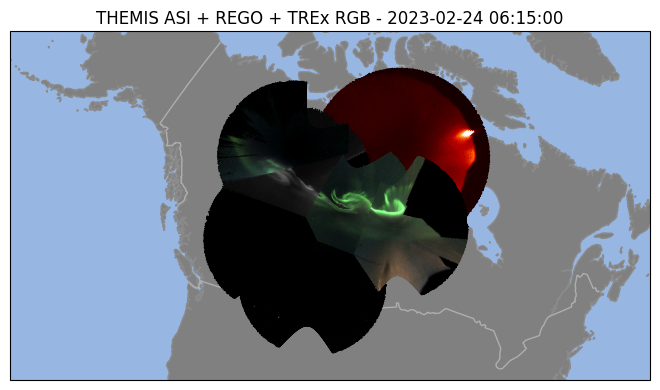

In [24]:
# plot mosaic
map_extent = [-145, -65, 35, 70]
mosaic.plot(map_extent, title="THEMIS ASI + REGO + TREx RGB - %s" % (data_list_110km[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))

**Note**

In practice, it is not really useful to mask between REGO and THEMIS/RGB. We do it here as just an example.

Due to REGO's narrow band nature, the imagers are not looking at the same thing.